In [3]:
import numpy as np
import matplotlib.pyplot as plt
from u import *
from time import sleep

<IPython.core.display.Javascript object>


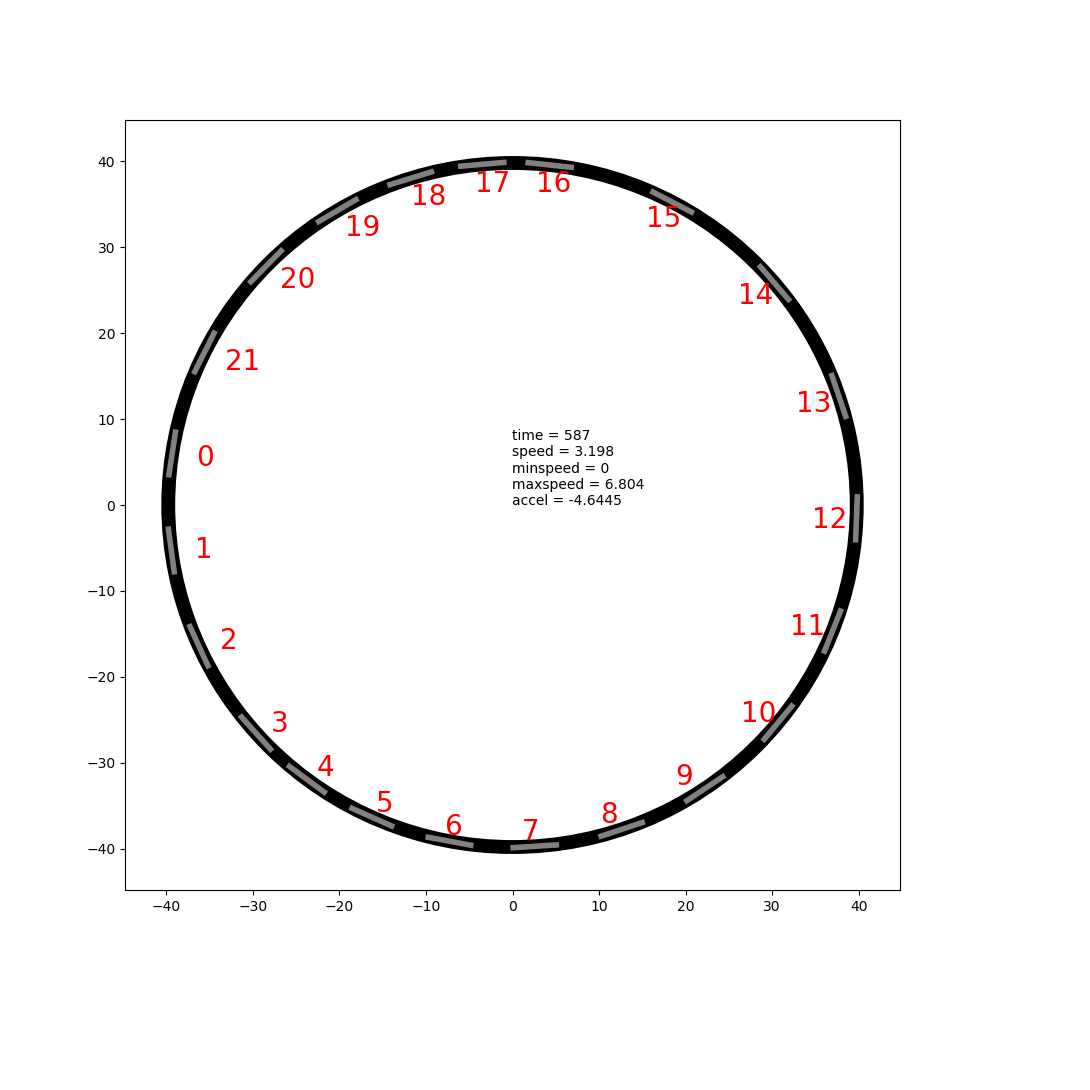

KeyboardInterrupt: 

In [94]:
%matplotlib notebook
def setup_plot(vehicles):
    circle = plt.Circle((0, 0), radius, color='black', linewidth=10, fill=False)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.add_artist(circle)
    
    def update_plt(veh):
        angle = veh.pos / radius
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        slope = np.array([y, -x])
        offset = 0.5 * L_veh * slope / np.linalg.norm(slope)
        center = np.array([x, y])
        veh.plt_line.set_data(*zip(center + offset, center - offset))
        veh.plt_text.set_position((0.9 * x - 0.03 * radius, 0.95 * y - 0.03 * radius))
        
    import types
    for veh in vehicles:
        veh.update_plt = types.MethodType(update_plt, veh)
        veh.plt_line, = ax.plot([0, 1], [0, 1], color='gray', linewidth=4)
        veh.plt_text = ax.text(0, 0, f'{veh.i}', color='red', fontsize=20)
        veh.update_plt()
    plt.xlim((-radius - 5, radius + 5))
    plt.ylim((-radius - 5, radius + 5))

    text = plt.text(0, 0, '')
    def draw(t):
        texts = [
            ('time', t),
            ('speed', np.mean([veh.speed for veh in vehicles])),
            ('minspeed', np.min([veh.speed for veh in vehicles])),
            ('maxspeed', np.max([veh.speed for veh in vehicles])),
            ('accel', np.mean([veh.accel for veh in vehicles]))
        ]
        text.set_text('\n'.join('%s = %.5g' % kv for kv in texts))
        fig.canvas.draw()
        fig.canvas.flush_events()
    draw(0)
    return draw

n_veh = 22
L_veh = 5
circ = 250
radius = circ / 2 / np.pi
N = 3000
step_size = 1

IDM = dict(
    accel=2.6,
    decel=4.5,
    sigma=0.5,
    tau=1.0,  # past 1 at sim_step=0.1 you no longer see waves
    minGap=2.5,
    maxSpeed=30,
    speedFactor=1.0,
    speedDev=0.1,
    impatience=0.5,
    carFollowModel='IDM',
)
delta = 4
v_0 = 30
s_0 = 2
T_headway = 1
a = 1
b = 1.5

vehicles = [Namespace(
    i=i,
    speed=np.clip(np.random.normal(0, 4), 0, np.inf),
    accel=0,
    pos=np.random.normal(circ * i / n_veh)) for i in range(n_veh)]
redraw = setup_plot(vehicles)

def update_speed(veh, vehicles):
    next_veh = vehicles[(veh.i + 1) % n_veh]
    
    headway = next_veh.pos - veh.pos - L_veh + circ * (next_veh.i == 0)
    v_diff = veh.speed - next_veh.speed
    
    s_star = s_0 + veh.speed * T_headway + veh.speed * v_diff / (2 * np.sqrt(a * b))
    veh.accel = a * (1 - (veh.speed / v_0) ** delta - (s_star / headway) ** 2)
    
    veh.speed = max(veh.speed + step_size * veh.accel, 0)

for n in range(N):
    for veh in vehicles:
        update_speed(veh, vehicles)
    
    for veh in vehicles:
        veh.pos = veh.pos + step_size * veh.speed
        veh.update_plt()
    if (n + 1) % int(1 / step_size) == 0:
        redraw(n + 1)